# NYT Crossword

## Download data

In [1]:
!rm nyt
!wget https://gist.githubusercontent.com/kedarv/db09704fa4d83507d804641fce7ab73a/raw/09b7107b1a8e7bb3d1c3cf0f4ed9236376dc4af0/nyt

--2020-01-01 20:36:42--  https://gist.githubusercontent.com/kedarv/db09704fa4d83507d804641fce7ab73a/raw/09b7107b1a8e7bb3d1c3cf0f4ed9236376dc4af0/nyt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61549 (60K) [text/plain]
Saving to: ‘nyt’

nyt                 100%[===================>]  60.11K  --.-KB/s    in 0.02s   

2020-01-01 20:36:42 (3.05 MB/s) - ‘nyt’ saved [61549/61549]



In [2]:
# Quick look at data format
!head -n 5 nyt

[
    {
        "author": "Ankit Pancakes",
        "time": "0:14",
        "timestamp_ms": 1576644059344


In [98]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

pd.set_option('display.max_rows', 10)

In [4]:
with open('nyt', 'r') as f:
    df = pd.read_json(f)
    # timezone bullshit
    df['timestamp_ms'] = df['timestamp_ms'].dt.tz_localize('GMT').dt.tz_convert('America/Los_Angeles')

In [5]:
display(df)

,author,time,timestamp_ms
0,Ankit Pancakes,0:14,2019-12-17 20:40:59.344000-08:00
1,Paige Rossi,0:21,2019-12-17 20:03:34.077000-08:00
2,Jenna Dambek,1:54,2019-12-17 19:49:59.569000-08:00
3,Kedar Vaidya,0:42,2019-12-17 19:21:04.959000-08:00
4,Seungyeon Shin,1:33,2019-12-17 19:18:54.673000-08:00
...,...,...,...
559,Kedar Vaidya,2:08,2019-09-16 20:46:53.663000-07:00
560,Nicky Semenza,1:36,2019-09-16 20:06:51.710000-07:00
561,Kedar Vaidya,3:05,2019-09-16 17:38:35.285000-07:00
562,Nicky Semenza,1:34,2019-09-15 16:03:10.465000-07:00


## Clean up data

In [6]:
# Days and cut-off hour (mini release time)
# 7 PM Pacific for Monday - Friday inclusive
# 3 PM Pacific for Saturday, Sunday
cutoff = lambda x: 19 if x < 5 else 15

In [7]:
[cutoff(x) for x in range(0,7)]

[19, 19, 19, 19, 19, 15, 15]

In [8]:
# Use newspaper-day instead of completion-day
df['day'] = [datetime.date(ts.year, ts.month, ts.day) + datetime.timedelta(days=1) \
            if ts.hour >= cutoff(ts.dayofweek) else datetime.date(ts.year, ts.month, ts.day) for ts in df['timestamp_ms']]

In [9]:
find_dups = lambda x: x[x.duplicated(['author', 'day'], keep=False)]
display(find_dups(df))

,author,time,timestamp_ms,day
36,Jessica Jiang,1:26,2019-12-13 20:02:53.918000-08:00,2019-12-14
37,Jessica Jiang,1:28,2019-12-13 20:01:08.854000-08:00,2019-12-14
65,Jessica Jiang,10:04,2019-12-09 20:39:11.843000-08:00,2019-12-10
66,Jessica Jiang,10:04,2019-12-09 20:39:00.040000-08:00,2019-12-10
128,Ankit Pancakes,0:41,2019-12-01 22:18:33.158000-08:00,2019-12-02
...,...,...,...,...
533,Kedar Vaidya,2:59,2019-10-03 19:39:31.028000-07:00,2019-10-04
534,Usmann Khan,1:42,2019-10-03 19:35:03.192000-07:00,2019-10-04
537,Usmann Khan,1:28,2019-10-03 19:29:35.912000-07:00,2019-10-04
549,Ankit Pancakes,2:30,2019-09-29 10:00:45.619000-07:00,2019-09-29


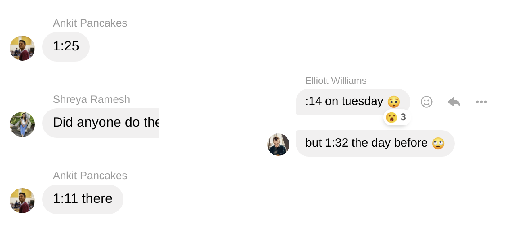

In [10]:
# Example duplicates ...
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(mpimg.imread('dup1.png'))
ax[1].imshow(mpimg.imread('dup2.png'))

In [11]:
# Delete all duplicates because I can't be bothered to scroll to each one in chat and look at them
print('before: {} dups in {} rows'.format(len(find_dups(df)), len(df['author'])))
df = df.drop_duplicates(['author', 'day'], keep=False)
print('after: {} dups in {} rows'.format(len(find_dups(df)), len(df['author'])))

before: 42 dups in 564 rows
after: 0 dups in 522 rows


In [12]:
# Transform times to secs
all_secs = []
for time in df['time']:
    if time.startswith(':'):
        time = '0' + time
    times = time.split(':')
    secs = 60*(int(times[0])) + int(times[1])
    all_secs.append(secs)

In [13]:
# Spot check
list(zip(all_secs, df['time']))[:5]

[(14, '0:14'), (21, '0:21'), (114, '1:54'), (42, '0:42'), (93, '1:33')]

In [14]:
# Looks good ....
df['time'] = all_secs

## Analyze Data

In [15]:
import plotly.express as px

### Question: What data is there?

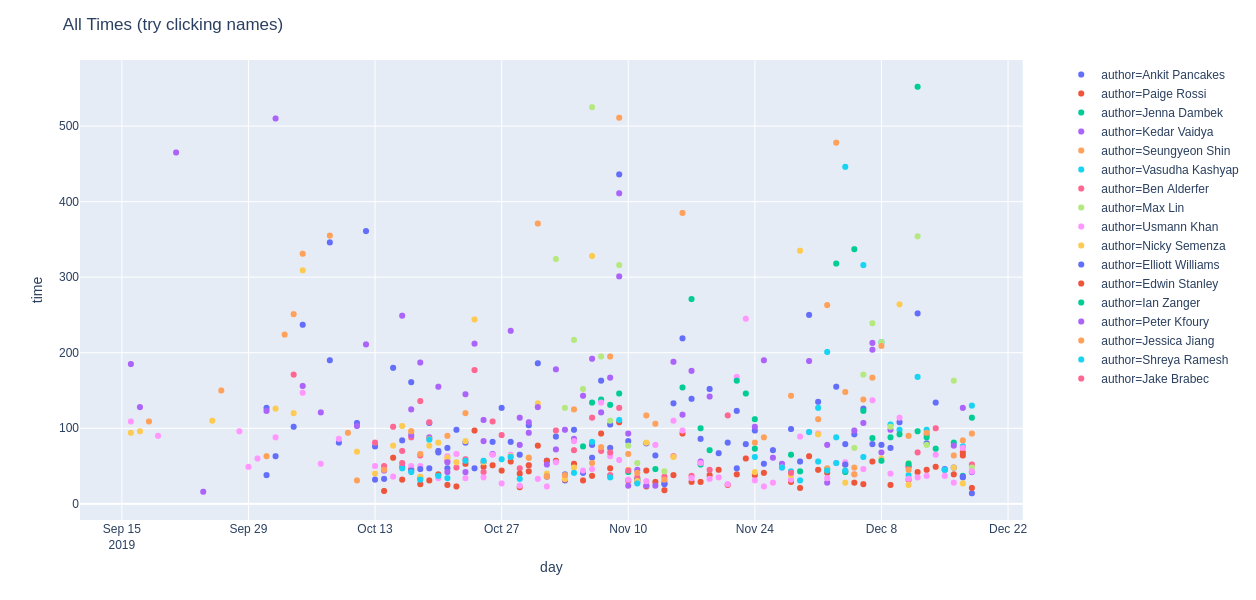

In [18]:
fig = px.scatter(df, x="day", y="time", color="author")
fig.update_layout(title="All Times (try clicking names)")
fig.show()

### Question: How do we do as a group? 

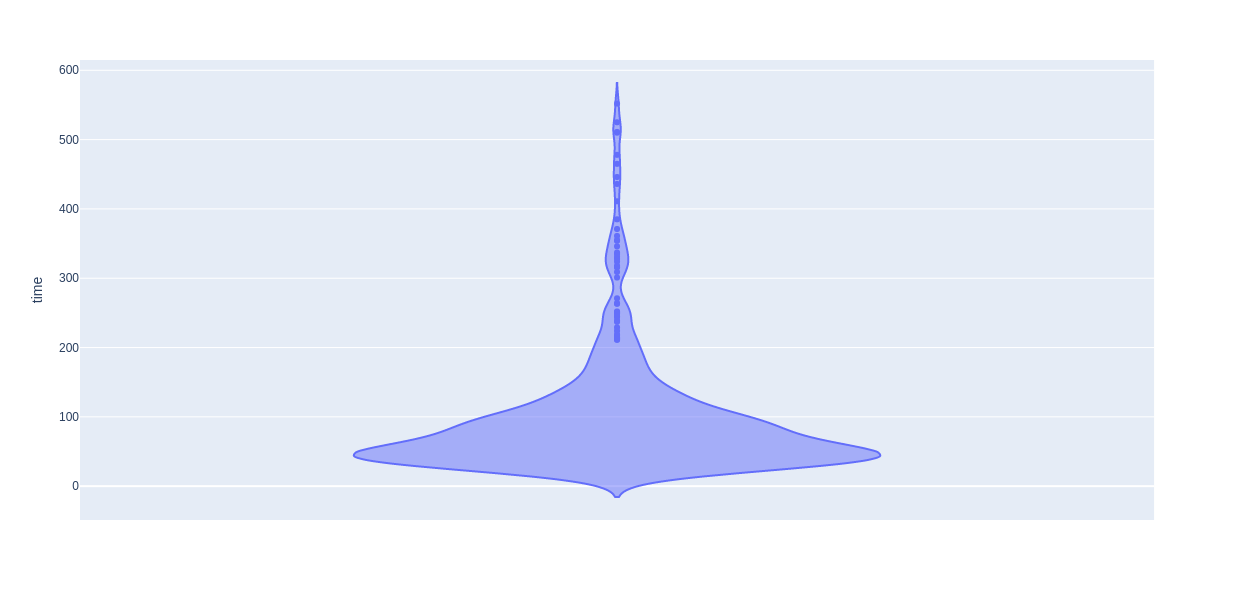

In [21]:
fig = px.violin(df, y='time')
fig.show()

### Question: How do we do individually?

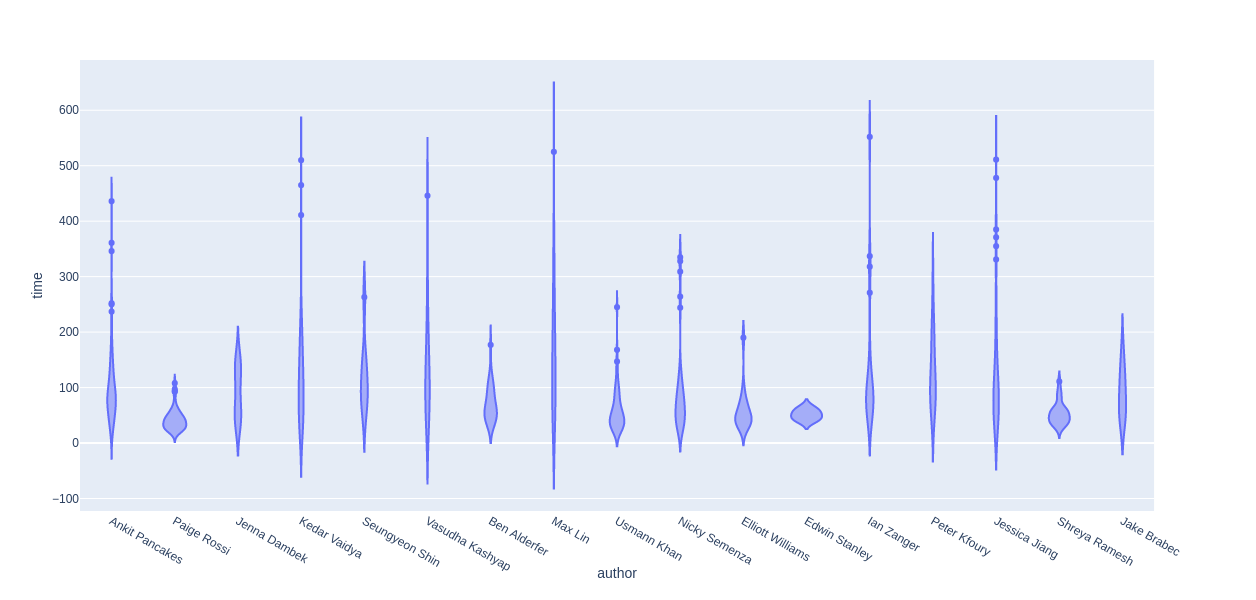

In [23]:
fig = px.violin(df, y='time', x='author')
fig.show()

In [129]:
min_day = min(df['day'])
max_day = max(df['day'])
cur_day = min_day

In [130]:
wins = []
while cur_day <= max_day:
    cur_df = df[df['day'] == cur_day]
    if len(cur_df) == 0:
        cur_day += datetime.timedelta(days=1)
        continue
    min_time = min(cur_df['time'])
    winning_authors = list(cur_df[cur_df['time'] == min_time]['author'])
    wins.extend(winning_authors)
    cur_day += datetime.timedelta(days=1)

In [131]:
wins = pd.DataFrame({'wins':{i:wins.count(i) for i in set(wins)}})
wins['author'] = wins.index

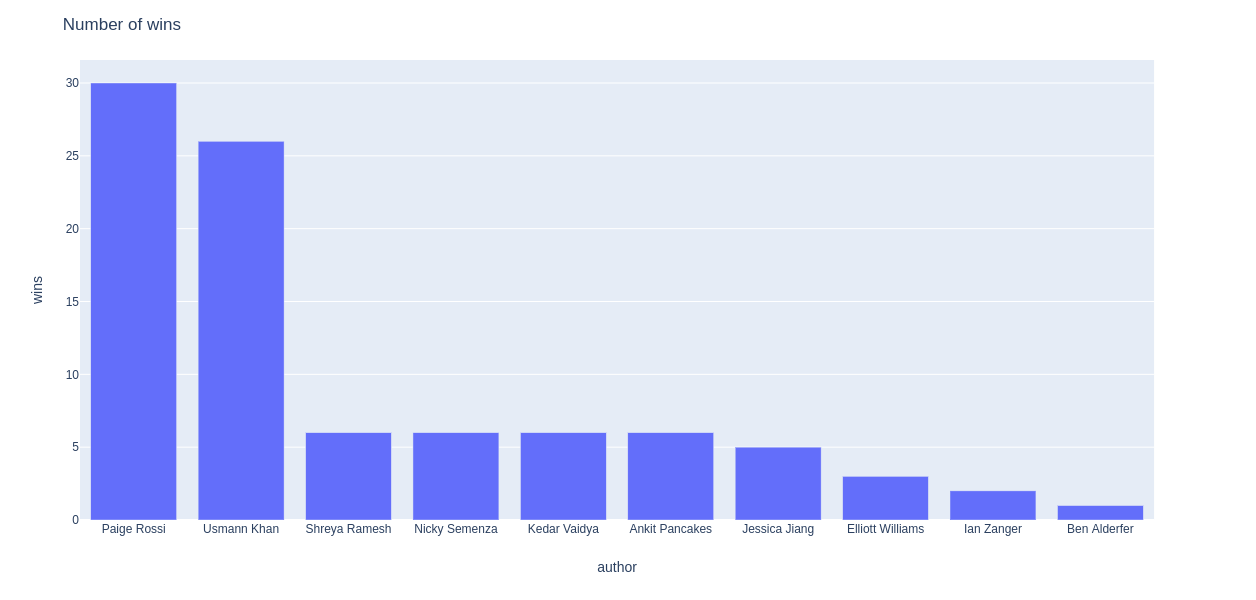

In [138]:
px.bar(wins, y='wins', x='author').update_xaxes(categoryorder='total descending').update_layout(title='Number of wins')

### Question: How much do we post?

In [139]:
posts = df['author'].value_counts().to_frame()
posts['val'] = posts['author']
posts['author'] = posts.index

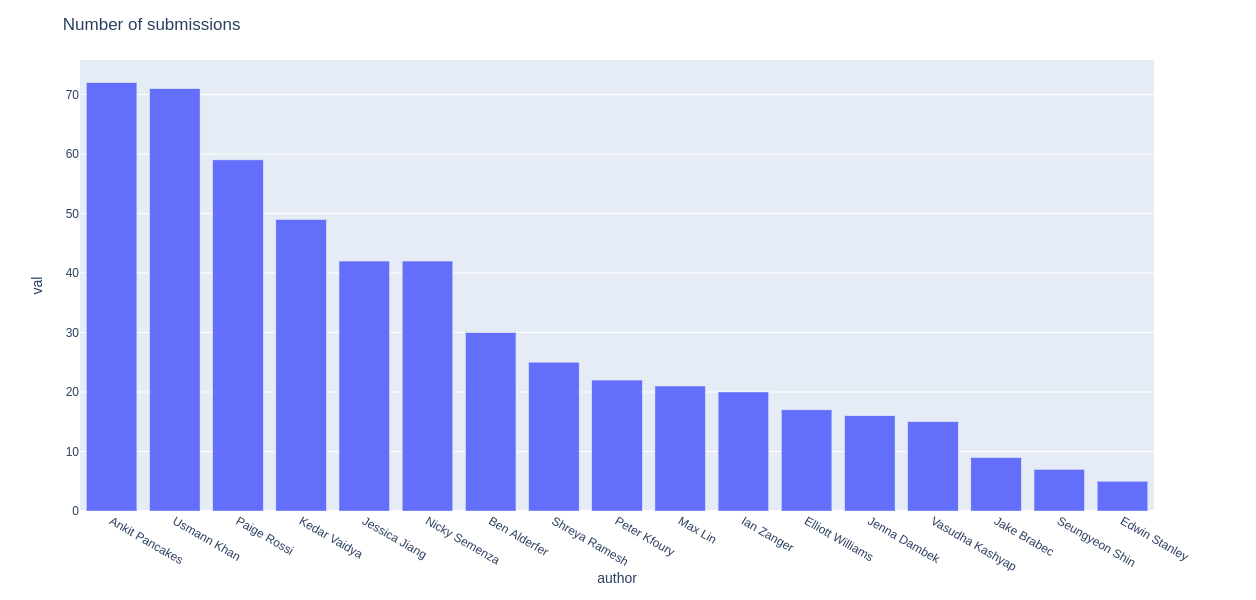

In [141]:
px.bar(posts, y='val', x='author').update_layout(title='Number of submissions')